<a href="https://colab.research.google.com/github/arthurnovello/ECM514-Ciencia_dos_Dados/blob/master/AUS_ANN_ECM514.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais com valores missing

In [1]:
#Bibliotecas utilizadas para classificação e exportação da árvore gerada
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#Biblioteca para facilitar a separação dos dataset em dados de traino e teste
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
#Pandas é uma biblioteca que facilita a ingestão e manipulação de dados
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from datetime import datetime

#enabling to plot using plotlib in the notebook
%matplotlib inline
%pylab inline


from keras.models import Sequential
from keras.layers import Dense, Activation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ecm514_datasets/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

## Preparando a base


In [4]:
df_novo = df.drop(['RISK_MM'], axis=1)
df_novo.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df_novo['Date'] = pd.to_datetime(df_novo['Date'])
df_novo['Date'] = pd.to_numeric(df_novo['Date'])

In [6]:
df_novo.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [7]:
df_novo['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', nan, 'E', 'SSW'], dtype=object)

In [8]:
df_novo['WindGustDir'] = df_novo['WindGustDir'].map( {'W' : 0, 'WNW' : 1, 'WSW' : 2, 'NE': 3,
                                    'NNW': 4, 'N': 5, 'NNE': 6, 'SW': 7, 'ENE': 8, 
                                    'SSE': 9, 'S': 10, 'NW': 11, 'SE': 12, 'ESE': 13, 
                                    'E': 14, 'SSW': 15})

In [9]:
df_novo['WindDir9am'].unique()

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', nan, 'SSW', 'N',
       'WSW', 'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object)

In [10]:
df_novo['WindDir9am'] = df_novo['WindDir9am'].map( {'W' : 0, 'WNW' : 1, 'WSW' : 2, 'NE': 3,
                                    'NNW': 4, 'N': 5, 'NNE': 6, 'SW': 7, 'ENE': 8, 
                                    'SSE': 9, 'S': 10, 'NW': 11, 'SE': 12, 'ESE': 13, 
                                    'E': 14, 'SSW': 15})

In [11]:
df_novo['WindDir3pm'].unique()

array(['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
       'SW', 'SE', 'N', 'S', 'NNE', nan, 'NE'], dtype=object)

In [12]:
df_novo['WindDir3pm'] = df_novo['WindDir3pm'].map( {'W' : 0, 'WNW' : 1, 'WSW' : 2, 'NE': 3,
                                    'NNW': 4, 'N': 5, 'NNE': 6, 'SW': 7, 'ENE': 8, 
                                    'SSE': 9, 'S': 10, 'NW': 11, 'SE': 12, 'ESE': 13, 
                                    'E': 14, 'SSW': 15})

In [13]:
df_novo['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [14]:
df_novo['Location'] = df_novo['Location'].map( {'Albury': 0, 'BadgerysCreek': 1, 
       'Newcastle': 2, 'NorahHead': 3, 'NorfolkIsland': 4, 'Penrith': 5, 'Richmond': 6,
       'Sydney': 7, 'SydneyAirport': 8, 'WaggaWagga': 9, 'Williamtown': 10,
       'Wollongong': 11, 'Canberra': 12, 'Tuggeranong': 13, 'MountGinini': 15, 'Ballarat': 16,
       'Bendigo': 17, 'Sale': 18, 'MelbourneAirport': 19, 'Melbourne': 20, 'Mildura': 21,
       'Nhil': 22, 'Portland': 23, 'Watsonia': 24, 'Dartmoor': 25, 'Brisbane': 26, 'Cairns': 27,
       'GoldCoast': 28, 'Townsville': 29, 'Adelaide': 30, 'MountGambier': 31, 'Nuriootpa': 32,
       'Woomera': 33, 'Albany': 34, 'Witchcliffe': 35, 'PearceRAAF': 36, 'PerthAirport': 37,
       'Perth': 38, 'SalmonGums': 39, 'Walpole': 40, 'Hobart': 41, 'Launceston': 42,
       'AliceSprings': 43, 'Darwin': 44, 'Katherine': 45, 'Uluru': 46, 'Cobar': 47, 'CoffsHarbour': 48,
       'Moree': 49})

In [15]:
df_novo['RainToday'].unique()

array(['No', 'Yes', nan], dtype=object)

In [16]:
df_novo['RainToday'] = df_novo['RainToday'].map( {'No': 0, 'Yes': 1})
df_novo.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1228089600000000000,0,13.4,22.9,0.6,NaN,NaN,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,No
1,1228176000000000000,0,7.4,25.1,0.0,NaN,NaN,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,No
2,1228262400000000000,0,12.9,25.7,0.0,NaN,NaN,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,No
3,1228348800000000000,0,9.2,28.0,0.0,NaN,NaN,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,No
4,1228435200000000000,0,17.5,32.3,1.0,NaN,NaN,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,No


In [17]:
df_novo['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [18]:
df_novo['RainTomorrow'] = df_novo['RainTomorrow'].map( {'No': 0, 'Yes': 1})
df_novo.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1228089600000000000,0,13.4,22.9,0.6,NaN,NaN,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,1228176000000000000,0,7.4,25.1,0.0,NaN,NaN,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,1228262400000000000,0,12.9,25.7,0.0,NaN,NaN,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0
3,1228348800000000000,0,9.2,28.0,0.0,NaN,NaN,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0
4,1228435200000000000,0,17.5,32.3,1.0,NaN,NaN,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0


## Substituindo os valores NaN pela Média da feature

In [19]:
mean_MinTemp = df_novo['MinTemp'].mean()
mean_MaxTemp = df_novo['MaxTemp'].mean()
mean_Rainfall = df_novo['Rainfall'].mean()
mean_Evaporation = df_novo['Evaporation'].mean()
mean_Sunshine = df_novo['Sunshine'].mean()
# mean_WindGustDir = df_novo['WindGustDir'].mean()
mean_WindGustSpeed = df_novo['WindGustSpeed'].mean()
# mean_WindDir9am = df_novo['WindDir9am'].mean()
# mean_WindDir3pm = df_novo['WindDir3pm'].mean()
mean_WindSpeed9am = df_novo['WindSpeed9am'].mean()
mean_WindSpeed3pm = df_novo['WindSpeed3pm'].mean()
mean_Humidity9am = df_novo['Humidity9am'].mean()
mean_Humidity3pm = df_novo['Humidity3pm'].mean()
mean_Pressure9am = df_novo['Pressure9am'].mean()
mean_Pressure3pm = df_novo['Pressure3pm'].mean()
mean_Cloud9am = df_novo['Cloud9am'].mean()
mean_Cloud3pm = df_novo['Cloud3pm'].mean()
mean_Temp9am = df_novo['Temp9am'].mean()
mean_Temp3pm = df_novo['Temp3pm'].mean()
# mean_RainToday = df_novo['RainToday'].mean()

medias = {'MinTemp': mean_MinTemp, 'MaxTemp': mean_MaxTemp, 
          'Rainfall': mean_Rainfall, 'Evaporation': mean_Evaporation,
          'Sunshine': mean_Sunshine, 'WindGustSpeed': mean_WindGustSpeed,
          'WindSpeed9am': mean_WindSpeed9am, 'WindSpeed3pm': mean_WindSpeed3pm,
          'Humidity9am': mean_Humidity9am, 'Humidity3pm': mean_Humidity3pm,
          'Pressure9am': mean_Pressure9am, 'Pressure3pm': mean_Pressure3pm,
          'Cloud9am': mean_Cloud9am, 'Cloud3pm': mean_Cloud3pm, 'Temp9am': mean_Temp9am,
          'Temp3pm': mean_Temp3pm}
medias

{'Cloud3pm': 4.503166899728551,
 'Cloud9am': 4.437189391885787,
 'Evaporation': 5.469824216349123,
 'Humidity3pm': 51.482606091656265,
 'Humidity9am': 68.8438103105705,
 'MaxTemp': 23.226784191272444,
 'MinTemp': 12.186399728729098,
 'Pressure3pm': 1015.258203537907,
 'Pressure9am': 1017.6537584159781,
 'Rainfall': 2.3499740743111954,
 'Sunshine': 7.624853113193571,
 'Temp3pm': 21.68723497314744,
 'Temp9am': 16.98750858170133,
 'WindGustSpeed': 39.98429165757619,
 'WindSpeed3pm': 18.63757586179718,
 'WindSpeed9am': 14.001988000994}

In [20]:
df_media = df_novo.fillna(value=medias)
df_media.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1228089600000000000,0,13.4,22.9,0.6,5.469824,7.624853,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,0.0,0
1,1228176000000000000,0,7.4,25.1,0.0,5.469824,7.624853,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,0.0,0
2,1228262400000000000,0,12.9,25.7,0.0,5.469824,7.624853,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,0.0,0
3,1228348800000000000,0,9.2,28.0,0.0,5.469824,7.624853,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,0.0,0
4,1228435200000000000,0,17.5,32.3,1.0,5.469824,7.624853,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0


In [21]:
df_media.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustDir       9330
WindGustSpeed        0
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
RainToday         1406
RainTomorrow         0
dtype: int64

In [30]:
df_media = df_media.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])
x = df_media.iloc[:,0:18]
y = df_media['RainTomorrow']
x.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,1228089600000000000,0,13.4,22.9,0.6,5.469824,7.624853,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8
1,1228176000000000000,0,7.4,25.1,0.0,5.469824,7.624853,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3
2,1228262400000000000,0,12.9,25.7,0.0,5.469824,7.624853,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2
3,1228348800000000000,0,9.2,28.0,0.0,5.469824,7.624853,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5
4,1228435200000000000,0,17.5,32.3,1.0,5.469824,7.624853,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7


In [31]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, 
                                                        random_state = 2556)

In [32]:
x_treino.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
32434,1463875200000000000,7,14.5,22.0,0.0,2.000000,9.100000,24.0,13.0,9.0,82.0,66.0,1024.400000,1020.200000,1.000000,4.000000,16.0,21.8
50505,1475625600000000000,13,4.6,14.3,11.6,5.469824,7.624853,50.0,24.0,28.0,58.0,48.0,1014.900000,1014.000000,4.437189,4.503167,8.3,12.1
105624,1467849600000000000,33,5.1,11.8,0.0,1.200000,7.624853,22.0,0.0,9.0,99.0,78.0,1024.500000,1021.400000,7.000000,4.503167,6.4,11.2
123091,1431907200000000000,39,12.0,18.7,1.6,5.469824,7.624853,54.0,30.0,19.0,72.0,62.0,1017.653758,1015.258204,4.437189,4.503167,14.5,18.0
79057,1262649600000000000,25,6.8,24.4,0.0,4.200000,11.500000,41.0,11.0,20.0,70.0,42.0,1016.600000,1016.200000,4.437189,4.503167,17.3,23.6


In [38]:
	model = Sequential()
	model.add(Dense(18, input_dim=18, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_treino.values, y_treino.values, batch_size=10, epochs=10)

Epoch 1/10
99535/99535 [==============================] - 24s 237us/step - loss: 619985074293428.7500 - accuracy: 0.6520
Epoch 2/10
99535/99535 [==============================] - 23s 230us/step - loss: 369221496029303.9375 - accuracy: 0.6533
Epoch 3/10
99535/99535 [==============================] - 23s 235us/step - loss: 353234295813379.3125 - accuracy: 0.6514
Epoch 4/10
99535/99535 [==============================] - 23s 229us/step - loss: 341413417397313.3125 - accuracy: 0.6535
Epoch 5/10
99535/99535 [==============================] - 23s 229us/step - loss: 304489208615215.5000 - accuracy: 0.6534
Epoch 6/10
99535/99535 [==============================] - 23s 232us/step - loss: 298004344846216.5625 - accuracy: 0.6501
Epoch 7/10
99535/99535 [==============================] - 23s 233us/step - loss: 271442096349564.2500 - accuracy: 0.6527
Epoch 8/10
99535/99535 [==============================] - 23s 230us/step - loss: 258264951301661.0000 - accuracy: 0.6511
Epoch 9/10
99535/99535 [========

In [40]:
model.evaluate(x_teste,y_teste,batch_size=10)

42658/42658 [==============================] - 5s 111us/step


[469945889090221.5, 0.7765718102455139]

## Substituindo os valores NaN pela Mediana da feature

In [43]:
median_MinTemp = df_novo['MinTemp'].median()
median_MaxTemp = df_novo['MaxTemp'].median()
median_Rainfall = df_novo['Rainfall'].median()
median_Evaporation = df_novo['Evaporation'].median()
median_Sunshine = df_novo['Sunshine'].median()
# median_WindGustDir = df_novo['WindGustDir'].median()
median_WindGustSpeed = df_novo['WindGustSpeed'].median()
# median_WindDir9am = df_novo['WindDir9am'].median()
# median_WindDir3pm = df_novo['WindDir3pm'].median()
median_WindSpeed9am = df_novo['WindSpeed9am'].median()
median_WindSpeed3pm = df_novo['WindSpeed3pm'].median()
median_Humidity9am = df_novo['Humidity9am'].median()
median_Humidity3pm = df_novo['Humidity3pm'].median()
median_Pressure9am = df_novo['Pressure9am'].median()
median_Pressure3pm = df_novo['Pressure3pm'].median()
median_Cloud9am = df_novo['Cloud9am'].median()
median_Cloud3pm = df_novo['Cloud3pm'].median()
median_Temp9am = df_novo['Temp9am'].median()
median_Temp3pm = df_novo['Temp3pm'].median()
# median_RainToday = df_novo['RainToday'].median()

mediana = {'MinTemp': median_MinTemp, 'MaxTemp': median_MaxTemp, 
          'Rainfall': median_Rainfall, 'Evaporation': median_Evaporation,
          'Sunshine': median_Sunshine, 'WindGustSpeed': median_WindGustSpeed,
          'WindSpeed9am': median_WindSpeed9am, 'WindSpeed3pm': median_WindSpeed3pm,
          'Humidity9am': median_Humidity9am, 'Humidity3pm': median_Humidity3pm,
          'Pressure9am': median_Pressure9am, 'Pressure3pm': median_Pressure3pm,
          'Cloud9am': median_Cloud9am, 'Cloud3pm': median_Cloud3pm, 'Temp9am': median_Temp9am,
          'Temp3pm': median_Temp3pm}
mediana

{'Cloud3pm': 5.0,
 'Cloud9am': 5.0,
 'Evaporation': 4.8,
 'Humidity3pm': 52.0,
 'Humidity9am': 70.0,
 'MaxTemp': 22.6,
 'MinTemp': 12.0,
 'Pressure3pm': 1015.2,
 'Pressure9am': 1017.6,
 'Rainfall': 0.0,
 'Sunshine': 8.5,
 'Temp3pm': 21.1,
 'Temp9am': 16.7,
 'WindGustSpeed': 39.0,
 'WindSpeed3pm': 19.0,
 'WindSpeed9am': 13.0}

In [44]:
df_mediana = df_novo.fillna(value=mediana)
df_mediana.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1228089600000000000,0,13.4,22.9,0.6,4.8,8.5,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0.0,0
1,1228176000000000000,0,7.4,25.1,0.0,4.8,8.5,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0.0,0
2,1228262400000000000,0,12.9,25.7,0.0,4.8,8.5,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0.0,0
3,1228348800000000000,0,9.2,28.0,0.0,4.8,8.5,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0.0,0
4,1228435200000000000,0,17.5,32.3,1.0,4.8,8.5,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0


In [45]:
df_mediana.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustDir       9330
WindGustSpeed        0
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
RainToday         1406
RainTomorrow         0
dtype: int64

In [48]:
df_mediana = df_mediana.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])
x = df_mediana.iloc[:,0:18]
y = df_mediana['RainTomorrow']
x.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,1228089600000000000,0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8
1,1228176000000000000,0,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3
2,1228262400000000000,0,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2
3,1228348800000000000,0,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5
4,1228435200000000000,0,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


In [49]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, 
                                                        random_state = 2556)
x_treino.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
32434,1463875200000000000,7,14.5,22.0,0.0,2.0,9.1,24.0,13.0,9.0,82.0,66.0,1024.4,1020.2,1.0,4.0,16.0,21.8
50505,1475625600000000000,13,4.6,14.3,11.6,4.8,8.5,50.0,24.0,28.0,58.0,48.0,1014.9,1014.0,5.0,5.0,8.3,12.1
105624,1467849600000000000,33,5.1,11.8,0.0,1.2,8.5,22.0,0.0,9.0,99.0,78.0,1024.5,1021.4,7.0,5.0,6.4,11.2
123091,1431907200000000000,39,12.0,18.7,1.6,4.8,8.5,54.0,30.0,19.0,72.0,62.0,1017.6,1015.2,5.0,5.0,14.5,18.0
79057,1262649600000000000,25,6.8,24.4,0.0,4.2,11.5,41.0,11.0,20.0,70.0,42.0,1016.6,1016.2,5.0,5.0,17.3,23.6


In [50]:
	model = Sequential()
	model.add(Dense(18, input_dim=18, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_treino.values, y_treino.values, batch_size=10, epochs=10)

Epoch 1/10
99535/99535 [==============================] - 23s 228us/step - loss: 2050754588668974.5000 - accuracy: 0.6468
Epoch 2/10
99535/99535 [==============================] - 23s 227us/step - loss: 138126972760545.6719 - accuracy: 0.6523
Epoch 3/10
99535/99535 [==============================] - 23s 231us/step - loss: 136372885936687.9531 - accuracy: 0.6517
Epoch 4/10
99535/99535 [==============================] - 23s 228us/step - loss: 124752708886168.4531 - accuracy: 0.6506
Epoch 5/10
99535/99535 [==============================] - 23s 228us/step - loss: 128649054450083.9531 - accuracy: 0.6512
Epoch 6/10
99535/99535 [==============================] - 23s 229us/step - loss: 117006484577210.6094 - accuracy: 0.6523
Epoch 7/10
99535/99535 [==============================] - 23s 229us/step - loss: 118852315530942.2969 - accuracy: 0.6518
Epoch 8/10
99535/99535 [==============================] - 23s 227us/step - loss: 108261313514021.7500 - accuracy: 0.6529
Epoch 9/10
99535/99535 [=======

In [52]:
model.evaluate(x_teste,y_teste,batch_size=10)

42658/42658 [==============================] - 5s 123us/step


[136506143827233.94, 0.7765718102455139]

In [53]:
0.7765718102455139 - 0.7765718102455139

0.0

## Assumindo valores por KNN para celulas NaN

In [54]:
imputer = KNNImputer()
df_knn = imputer.fit_transform(df_novo)


In [58]:
df_knn_b = pd.DataFrame(df_knn, columns=list(df_novo.columns))
df_knn_b.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1.228090e+18,0.0,13.4,22.9,0.6,7.12,10.86,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,4.6,16.9,21.8,0.0,0.0
1,1.228176e+18,0.0,7.4,25.1,0.0,7.08,10.90,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.2,4.4,17.2,24.3,0.0,0.0
2,1.228262e+18,0.0,12.9,25.7,0.0,6.28,9.66,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.6,2.0,21.0,23.2,0.0,0.0
3,1.228349e+18,0.0,9.2,28.0,0.0,5.64,8.26,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,3.8,5.2,18.1,26.5,0.0,0.0
4,1.228435e+18,0.0,17.5,32.3,1.0,5.40,8.50,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


In [59]:
df_knn_b.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [60]:
df_knn_b = df_knn_b.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])
x = df_knn_b.iloc[:,0:18]
y = df_knn_b['RainTomorrow']
x.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,1.228090e+18,0.0,13.4,22.9,0.6,7.12,10.86,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,4.6,16.9,21.8
1,1.228176e+18,0.0,7.4,25.1,0.0,7.08,10.90,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.2,4.4,17.2,24.3
2,1.228262e+18,0.0,12.9,25.7,0.0,6.28,9.66,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.6,2.0,21.0,23.2
3,1.228349e+18,0.0,9.2,28.0,0.0,5.64,8.26,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,3.8,5.2,18.1,26.5
4,1.228435e+18,0.0,17.5,32.3,1.0,5.40,8.50,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


In [61]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, 
                                                        random_state = 2556)
x_treino.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
32434,1.463875e+18,7.0,14.5,22.0,0.0,2.00,9.10,24.0,13.0,9.0,82.0,66.0,1024.40,1020.20,1.0,4.0,16.0,21.8
50505,1.475626e+18,13.0,4.6,14.3,11.6,4.56,8.42,50.0,24.0,28.0,58.0,48.0,1014.90,1014.00,1.8,5.0,8.3,12.1
105624,1.467850e+18,33.0,5.1,11.8,0.0,1.20,2.68,22.0,0.0,9.0,99.0,78.0,1024.50,1021.40,7.0,6.6,6.4,11.2
123091,1.431907e+18,39.0,12.0,18.7,1.6,4.12,6.74,54.0,30.0,19.0,72.0,62.0,1019.48,1018.82,3.2,5.4,14.5,18.0
79057,1.262650e+18,25.0,6.8,24.4,0.0,4.20,11.50,41.0,11.0,20.0,70.0,42.0,1016.60,1016.20,4.6,4.6,17.3,23.6


In [62]:
	model = Sequential()
	model.add(Dense(18, input_dim=18, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_treino.values, y_treino.values, batch_size=15, epochs=10)

Epoch 1/10
99535/99535 [==============================] - 15s 151us/step - loss: 602474143572170.8750 - accuracy: 0.6534
Epoch 2/10
99535/99535 [==============================] - 15s 150us/step - loss: 465510758881816.0625 - accuracy: 0.6510
Epoch 3/10
99535/99535 [==============================] - 15s 155us/step - loss: 444067294824180.1875 - accuracy: 0.6521
Epoch 4/10
99535/99535 [==============================] - 15s 155us/step - loss: 424393439023335.0625 - accuracy: 0.6548
Epoch 5/10
99535/99535 [==============================] - 15s 155us/step - loss: 423247238372217.6250 - accuracy: 0.6501
Epoch 6/10
99535/99535 [==============================] - 15s 150us/step - loss: 410123779133609.7500 - accuracy: 0.6524
Epoch 7/10
99535/99535 [==============================] - 15s 150us/step - loss: 425416294257758.6875 - accuracy: 0.6529
Epoch 8/10
99535/99535 [==============================] - 15s 155us/step - loss: 382437389518393.0000 - accuracy: 0.6515
Epoch 9/10
99535/99535 [========

In [63]:
model.evaluate(x_teste,y_teste,batch_size=10)

42658/42658 [==============================] - 5s 114us/step


[80430972767185.0, 0.7765718102455139]

In [64]:
model = Sequential([
                    Dense(18, input_dim=18, kernel_initializer='normal', activation='relu'),
                    Dense(44, kernel_initializer='normal', activation='relu'),
                    Dense(44, kernel_initializer='normal', activation='relu'),
                    Dense(1, kernel_initializer='normal', activation='sigmoid')
])
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.fit(x_treino.values, y_treino.values, batch_size=15, epochs=10)

Epoch 1/10
99535/99535 [==============================] - 18s 185us/step - loss: 810252451845.2211 - accuracy: 0.6926
Epoch 2/10
99535/99535 [==============================] - 18s 184us/step - loss: 0.5327 - accuracy: 0.7755
Epoch 3/10
99535/99535 [==============================] - 18s 184us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 4/10
99535/99535 [==============================] - 18s 185us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 5/10
99535/99535 [==============================] - 18s 184us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 6/10
99535/99535 [==============================] - 18s 184us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 7/10
99535/99535 [==============================] - 18s 183us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 8/10
99535/99535 [==============================] - 18s 184us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 9/10
99535/99535 [==============================] - 18s 185us/step - loss: 0.5326 - accuracy: 0.7755
Epoch 10/10
99535/99535 [=

In [65]:
model.evaluate(x_teste,y_teste,batch_size=10)

42658/42658 [==============================] - 5s 127us/step


[0.5312503736643098, 0.7765718102455139]

## Nova Tentativa

In [68]:
categorical = [var for var in df.columns if df[var].dtype=='O']
print('Categoricas:', categorical)

Categoricas: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [69]:
df[categorical].head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


In [70]:
df[categorical].isnull().sum()

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

In [72]:
for var in categorical: 
    
    print(df[var].value_counts())

2013-04-03    49
2016-06-25    49
2013-06-12    49
2016-10-07    49
2014-08-20    49
              ..
2007-12-02     1
2007-12-04     1
2007-11-02     1
2008-01-13     1
2008-01-30     1
Name: Date, Length: 3436, dtype: int64
Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
NorfolkIsland       2964

In [73]:
df['Date'] = pd.to_datetime(df['Date'])

In [74]:
df['Year'] = df['Date'].dt.year

df['Year'].head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int64

In [75]:
df['Month'] = df['Date'].dt.month

df['Month'].head()

0    12
1    12
2    12
3    12
4    12
Name: Month, dtype: int64

In [76]:
df['Day'] = df['Date'].dt.day

df['Day'].head()

0    1
1    2
2    3
3    4
4    5
Name: Day, dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  object        
 8   WindGustSpeed  132923 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Humidity9am    140419 non-null  float64       
 14  Humidity3pm    138583 non-null  float64       
 15  

In [78]:
df.drop('Date', axis=1, inplace = True)

In [79]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [80]:
pd.get_dummies(df.Location, drop_first=True).head()

,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
df.WindGustDir.value_counts()

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64

In [82]:
pd.get_dummies(df.WindGustDir, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [83]:
pd.get_dummies(df.WindGustDir, drop_first=True, dummy_na=True).sum(axis=0)

ENE    7992
ESE    7305
N      9033
NE     7060
NNE    6433
NNW    6561
NW     8003
S      8949
SE     9309
SSE    8993
SSW    8610
SW     8797
W      9780
WNW    8066
WSW    8901
NaN    9330
dtype: int64

In [84]:
pd.get_dummies(df.WindDir9am, drop_first=True, dummy_na=True).head()

pd.get_dummies(df.WindDir9am, drop_first=True, dummy_na=True).sum(axis=0)

ENE     7735
ESE     7558
N      11393
NE      7527
NNE     7948
NNW     7840
NW      8552
S       8493
SE      9162
SSE     8966
SSW     7448
SW      8237
W       8260
WNW     7194
WSW     6843
NaN    10013
dtype: int64

In [85]:
pd.get_dummies(df.WindDir3pm, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [86]:
pd.get_dummies(df.WindDir3pm, drop_first=True, dummy_na=True).sum(axis=0)


ENE     7724
ESE     8382
N       8667
NE      8164
NNE     6444
NNW     7733
NW      8468
S       9598
SE     10663
SSE     9142
SSW     8010
SW      9182
W       9911
WNW     8656
WSW     9329
NaN     3778
dtype: int64

In [87]:
pd.get_dummies(df.RainToday, drop_first=True, dummy_na=True).head()
pd.get_dummies(df.RainToday, drop_first=True, dummy_na=True).sum(axis=0)


Yes    31455
NaN     1406
dtype: int64

In [89]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print(round(df[numerical].describe()),2)

        MinTemp   MaxTemp  Rainfall  ...      Year     Month       Day
count  141556.0  141871.0  140787.0  ...  142193.0  142193.0  142193.0
mean       12.0      23.0       2.0  ...    2013.0       6.0      16.0
std         6.0       7.0       8.0  ...       3.0       3.0       9.0
min        -8.0      -5.0       0.0  ...    2007.0       1.0       1.0
25%         8.0      18.0       0.0  ...    2011.0       3.0       8.0
50%        12.0      23.0       0.0  ...    2013.0       6.0      16.0
75%        17.0      28.0       1.0  ...    2015.0       9.0      23.0
max        34.0      48.0     371.0  ...    2017.0      12.0      31.0

[8 rows x 20 columns] 2


Text(0, 0.5, 'WindSpeed3pm')

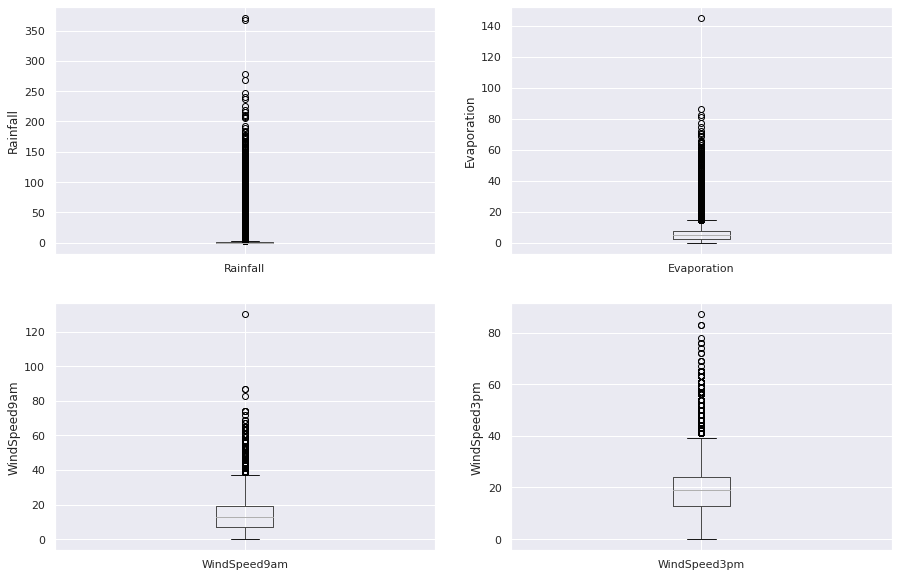

In [90]:

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = df.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')


plt.subplot(2, 2, 3)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 4)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

Text(0, 0.5, 'RainTomorrow')

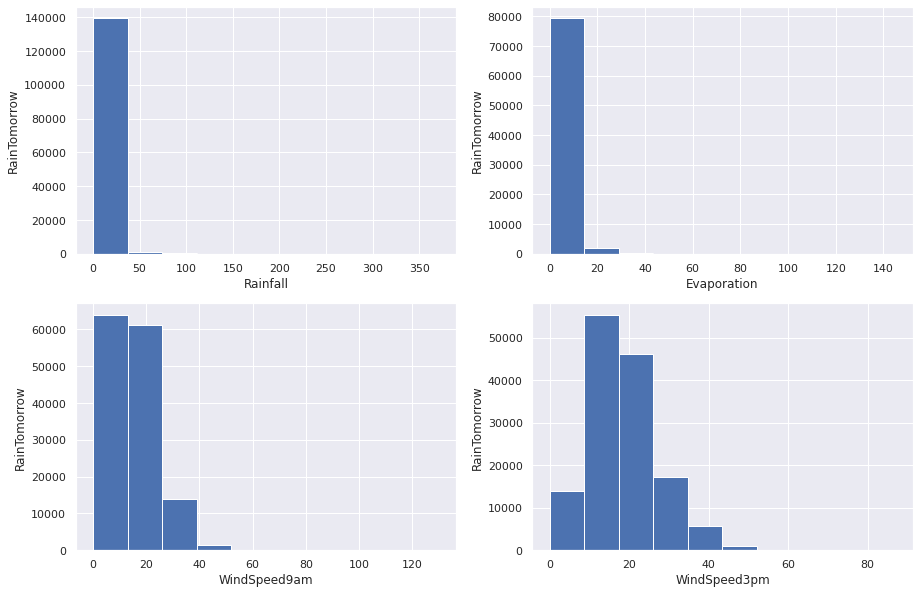

In [91]:

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.Rainfall.hist(bins=10)
fig.set_xlabel('Rainfall')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 2)
fig = df.Evaporation.hist(bins=10)
fig.set_xlabel('Evaporation')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 3)
fig = df.WindSpeed9am.hist(bins=10)
fig.set_xlabel('WindSpeed9am')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 4)
fig = df.WindSpeed3pm.hist(bins=10)
fig.set_xlabel('WindSpeed3pm')
fig.set_ylabel('RainTomorrow')

In [93]:

IQR = df.Rainfall.quantile(0.75) - df.Rainfall.quantile(0.25)
Lower_fence = df.Rainfall.quantile(0.25) - (IQR * 3)
Upper_fence = df.Rainfall.quantile(0.75) + (IQR * 3)
print(' outliers < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

 outliers < -2.4000000000000004 or > 3.2


In [94]:

IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
Lower_fence = df.Evaporation.quantile(0.25) - (IQR * 3)
Upper_fence = df.Evaporation.quantile(0.75) + (IQR * 3)
print(' outliers < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

 outliers < -11.800000000000002 or > 21.800000000000004


In [96]:

IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
Lower_fence = df.WindSpeed9am.quantile(0.25) - (IQR * 3)
Upper_fence = df.WindSpeed9am.quantile(0.75) + (IQR * 3)
print(' outliers < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

 outliers < -29.0 or > 55.0


In [97]:
IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
Lower_fence = df.WindSpeed3pm.quantile(0.25) - (IQR * 3)
Upper_fence = df.WindSpeed3pm.quantile(0.75) + (IQR * 3)
print(' outliers  < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

 outliers  < -20.0 or > 57.0


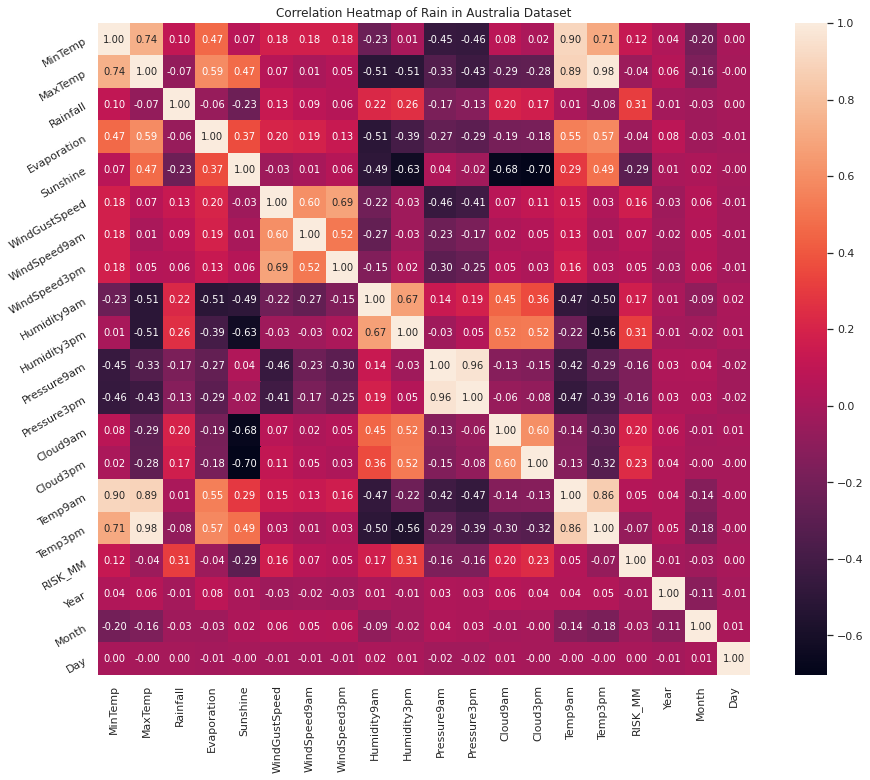

In [98]:
correlation = df.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

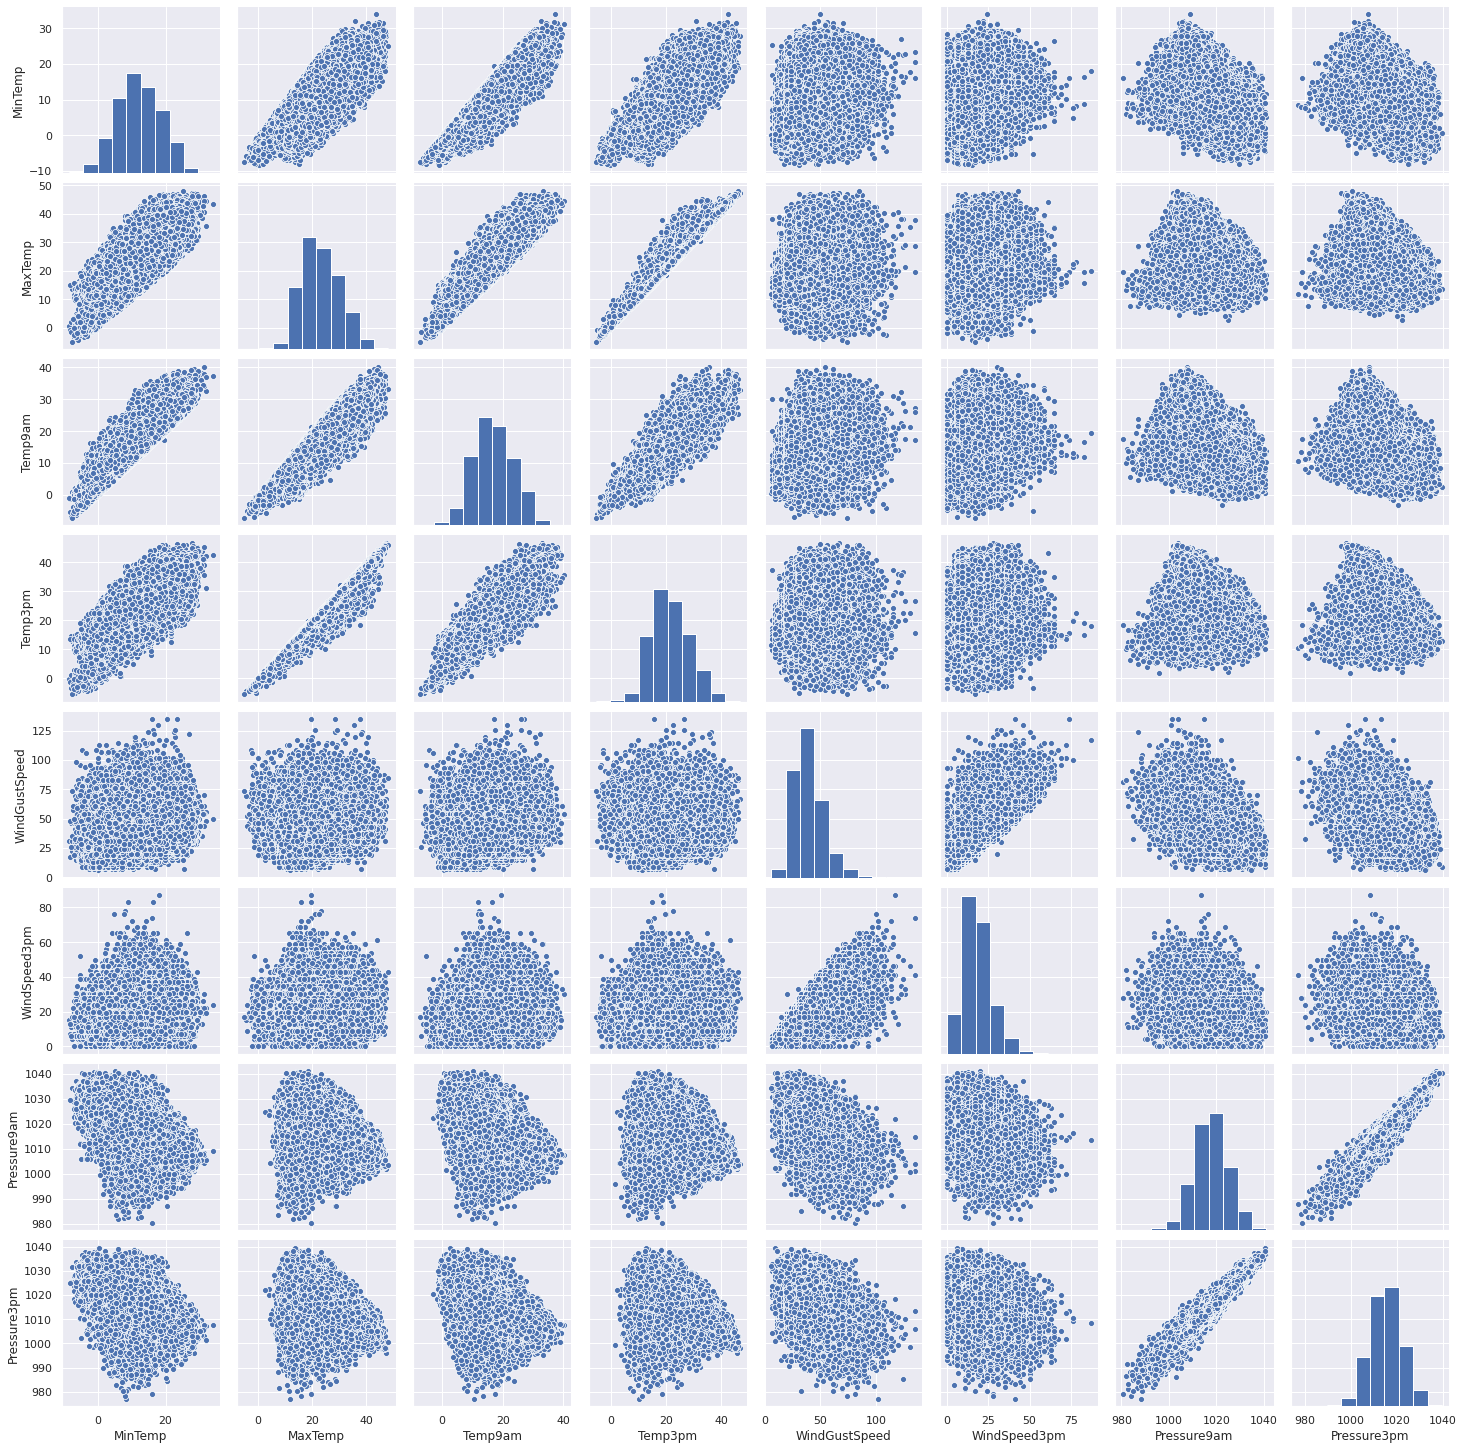

In [99]:
num_var = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']
sns.pairplot(df[num_var], kind='scatter', diag_kind='hist', palette='Rainbow')
plt.show()

In [100]:
X = df.drop(['RainTomorrow'], axis=1)

y = df['RainTomorrow']

In [120]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, 
                                                        random_state = 2556)
x_treino.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,Year,Month,Day
32434,Sydney,14.5,22.0,0.0,2.0,9.1,NNE,24.0,W,E,13.0,9.0,82.0,66.0,1024.4,1020.2,1.0,4.0,16.0,21.8,No,0.0,2016,5,22
50505,Tuggeranong,4.6,14.3,11.6,NaN,NaN,W,50.0,NW,WNW,24.0,28.0,58.0,48.0,1014.9,1014.0,NaN,NaN,8.3,12.1,Yes,0.0,2016,10,5
105624,Woomera,5.1,11.8,0.0,1.2,NaN,ESE,22.0,NaN,SE,0.0,9.0,99.0,78.0,1024.5,1021.4,7.0,NaN,6.4,11.2,No,0.2,2016,7,7
123091,SalmonGums,12.0,18.7,1.6,NaN,NaN,NW,54.0,WNW,WSW,30.0,19.0,72.0,62.0,NaN,NaN,NaN,NaN,14.5,18.0,Yes,1.2,2015,5,18
79057,Dartmoor,6.8,24.4,0.0,4.2,11.5,SSW,41.0,SSW,SW,11.0,20.0,70.0,42.0,1016.6,1016.2,NaN,NaN,17.3,23.6,No,0.0,2010,1,5


In [121]:
x_teste.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,Year,Month,Day
76499,Watsonia,14.5,21.2,0.0,4.2,6.6,SSW,31.0,SSE,SSW,9.0,15.0,69.0,56.0,1012.6,1012.9,7.0,5.0,15.2,19.1,No,0.0,2011,1,19
3021,BadgerysCreek,12.6,30.2,0.0,NaN,NaN,E,41.0,N,E,7.0,19.0,61.0,40.0,1014.3,1010.1,NaN,NaN,21.6,29.0,No,4.0,2009,1,11
54051,Ballarat,11.0,18.9,0.6,NaN,NaN,SSW,35.0,SW,S,17.0,19.0,98.0,65.0,1020.2,1019.9,7.0,8.0,12.3,17.4,No,0.2,2009,12,13
97132,MountGambier,6.8,15.7,0.0,0.8,5.4,N,22.0,NNE,NE,13.0,9.0,95.0,69.0,1016.8,1014.3,6.0,7.0,10.4,15.5,No,1.2,2009,6,5
18596,NorahHead,12.8,22.5,0.0,NaN,NaN,NNE,43.0,N,NE,11.0,24.0,79.0,76.0,1026.9,1023.5,NaN,NaN,17.4,18.7,No,0.0,2011,9,5


### Substitui com mediana e moda

In [105]:
for df1 in [x_treino, x_teste]:
    for col in numerical:
        col_median=x_treino[col].median()
        df1[col].fillna(col_median, inplace=True)           

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [106]:
x_treino[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RISK_MM          0
Year             0
Month            0
Day              0
dtype: int64

In [107]:
x_teste[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RISK_MM          0
Year             0
Month            0
Day              0
dtype: int64

In [111]:
for df2 in [x_treino, x_teste]:
    df2['WindGustDir'].fillna(x_treino['WindGustDir'].mode()[0], inplace=True)
    df2['WindDir9am'].fillna(x_treino['WindDir9am'].mode()[0], inplace=True)
    df2['WindDir3pm'].fillna(x_treino['WindDir3pm'].mode()[0], inplace=True)
    df2['RainToday'].fillna(x_treino['RainToday'].mode()[0], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [113]:
categorical = [col for col in x_treino.columns if x_treino[col].dtypes == 'O']
x_treino[categorical].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

In [114]:
x_teste[categorical].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

### Tratando outliers

In [116]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])

for df3 in [x_treino, x_teste]:
    df3['Rainfall'] = max_value(df3, 'Rainfall', 3.2)
    df3['Evaporation'] = max_value(df3, 'Evaporation', 21.8)
    df3['WindSpeed9am'] = max_value(df3, 'WindSpeed9am', 55)
    df3['WindSpeed3pm'] = max_value(df3, 'WindSpeed3pm', 57)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [123]:
x_treino[numerical].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,Year,Month,Day
count,99083.000000,99309.000000,98554.000000,56855.000000,52016.000000,93067.000000,98581.000000,97699.000000,98292.000000,97017.000000,89747.000000,89785.000000,61852.000000,59460.000000,98889.000000,97620.000000,99535.000000,99535.000000,99535.000000,99535.000000
mean,12.183499,23.220588,2.358668,5.465627,7.624312,40.020534,14.012477,18.673323,68.844301,51.505509,1017.636613,1015.240245,4.434295,4.499950,16.984234,21.676031,2.363374,2012.760627,6.405877,15.672497
std,6.397767,7.119918,8.590374,4.174875,3.790270,13.635492,8.907351,8.832303,19.063812,20.804408,7.105097,7.039145,2.888176,2.723348,6.491499,6.944776,8.458172,2.541722,3.429837,8.800780
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000,2013.000000,6.000000,16.000000
75%,16.800000,28.200000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000,2015.000000,9.000000,23.000000
max,33.900000,47.300000,371.000000,81.200000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1038.900000,9.000000,8.000000,39.100000,46.700000,371.000000,2017.000000,12.000000,31.000000


In [124]:
x_treino[categorical].head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
32434,Sydney,NNE,W,E,No
50505,Tuggeranong,W,NW,WNW,Yes
105624,Woomera,ESE,NaN,SE,No
123091,SalmonGums,NW,WNW,WSW,Yes
79057,Dartmoor,SSW,SSW,SW,No


In [126]:
!pip install category_encoders
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['RainToday'])

x_treino = encoder.fit_transform(x_treino)

x_teste = encoder.transform(x_teste)

     |████████████████████████████████| 81kB 5.1MB/s 


In [127]:
x_teste = pd.concat([x_teste[numerical], x_teste[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(x_teste.Location), 
                     pd.get_dummies(x_teste.WindGustDir),
                     pd.get_dummies(x_teste.WindDir9am),
                     pd.get_dummies(x_teste.WindDir3pm)], axis=1)

In [ ]:
x_treino = pd.concat([x_treino[numerical], x_treino[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(x_treino.Location), 
                     pd.get_dummies(x_treino.WindGustDir),
                     pd.get_dummies(x_treino.WindDir9am),
                     pd.get_dummies(x_treino.WindDir3pm)], axis=1)

In [ ]:
x_treino.head()

### Normalizando

In [119]:
from sklearn.preprocessing import MinMaxScaler
cols = x_treino.columns
scaler = MinMaxScaler()
x_treino = scaler.fit_transform(x_treino)
x_teste = scaler.transform(x_teste)

ValueError: ignored